## Configurations and libraries

**Important note**

Generate the `FER2013+` dataset before running the application


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from  torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import matplotlib.pyplot as plt
from datasets.FERPlusDataset import FERPlusDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
import random
import os
import CNN
from datetime import datetime

device = torch.device("mps" if torch.mps.is_available() else "cpu")

checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)  # Ensure the checkpoint directory exists

# device = "cpu"
# Paths to dataset directories
train_dir = "./data/FER2013Train"
val_dir = "./data/FER2013Valid"
test_dir = "./data/FER2013Test"

# Paths to labels
train_csv = "./data/FER2013Train/label.csv"
val_csv = "./data/FER2013Valid/label.csv"
test_csv = "./data/FER2013Test/label.csv"

In [2]:
def check_data_availability(image_dir, label_csv):
    if not os.path.exists(image_dir):
        print(f"Error: Directory {image_dir} does not exist.")
        return False

    png_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
    if len(png_files) == 0:
        print(f"Error: No .png files found in directory {image_dir}.")
        return False

    # Check if label CSV exists
    if not os.path.exists(label_csv):
        print(f"Error: Label file {label_csv} does not exist.")
        return False

    print(f"Data check passed for {image_dir} and {label_csv}.")
    return True

# Check all directories
if (
    check_data_availability(train_dir, train_csv) and
    check_data_availability(val_dir, val_csv) and
    check_data_availability(test_dir, test_csv)
):
    print("All data is available and ready for training!")
else:
    print("Data check failed. Please fix the errors and try again.")


Data check passed for ./data/FER2013Train and ./data/FER2013Train/label.csv.
Data check passed for ./data/FER2013Valid and ./data/FER2013Valid/label.csv.
Data check passed for ./data/FER2013Test and ./data/FER2013Test/label.csv.
All data is available and ready for training!


## Data Preprocessing

`Challenge:`

What is the proper way to augment dataset?

There are 2 ways to apply augmentation:
* On the fly (when loading custom `Dataset`, pass original image and augmented image)
* Create a separate augmented dataset and combine with original 

`Solution:`

We chose to create a separate dataset and combine it with original one.




In [3]:
# Apply transformations and augmentation
main_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor() ,  
    transforms.Normalize((0.5,), (0.5,), (0.5,),)  
])

train_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),  # Reduce rotation degrees
    transforms.ColorJitter(brightness=0.05, contrast=0.05),  # Subtle jitter
    transforms.RandomResizedCrop(size=(40, 40), scale=(0.9, 1.0)),  # Reduce crop range
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_first_dataset = FERPlusDataset(image_dir=train_dir, aug_transform=train_augmentation, transform=main_transform, label_csv=train_csv, mode="majority")

test_dataset = FERPlusDataset(image_dir=test_dir, aug_transform=None, transform=main_transform, label_csv=test_csv, mode="majority")
validation_dataset = FERPlusDataset(image_dir=val_dir, aug_transform=None, transform=main_transform, label_csv=val_csv, mode="majority")

# Create data loaders
batch_size = 64  
    
train_loader = DataLoader(train_first_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [4]:
# Debugging a sample
for img, label in train_loader:
    print(f"Image type: {type(img)}, Image shape: {img.shape}")
    break


Image type: <class 'torch.Tensor'>, Image shape: torch.Size([64, 3, 48, 48])


# Model Enhancements
## Transfer Learning
 Integrate Transfer Learning for Emotion Classification. In our case we will use ResNet model.

### 1. Import and Modify Pre-Trained Model

In [5]:
from torchvision import models

device = torch.device("mps" if torch.mps.is_available() else "cpu")

# Load Pre-Trained Model (ResNet50 in this example)
pretrained_model = models.resnet50(pretrained=True)

# Freeze the weights of the pre-trained layers to retain learned features.
for param in pretrained_model.parameters():
    param.requires_grad = False

# Replace the final classification layer to suit our classification needs
num_classes = 8
pretrained_model.fc = nn.Sequential(
            nn.Linear(pretrained_model.fc.in_features, 512),
            # nn.AdaptiveAvgPool2d(1),  # Global Average Pooling
            nn.Linear(in_features=512, out_features=256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=256, out_features=128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=128, out_features=num_classes)  # Output layer for num_emotions classes
        )


C:\Users\ruzte\PycharmProjects\data_ai_5_dl_project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ruzte\PycharmProjects\data_ai_5_dl_project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Train modified model

In [6]:
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience # Number of epochs to wait before stopping
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0

        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [7]:
def early_stopping_triggered(early_stopping, val_loss):
    """Check and handle early stopping condition."""
    early_stopping(val_loss)
    return early_stopping.early_stop

def train_one_epoch(model, train_loader, optimizer, criterion, device):
    """Train the model for one epoch and compute metrics."""
    model.train()
    running_loss = 0.0
    all_labels = []
    all_predictions = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Store predictions and labels for metrics
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    # Calculate metrics
    train_accuracy = accuracy_score(all_labels, all_predictions)
    train_precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=1)
    train_recall = recall_score(all_labels, all_predictions, average='weighted')
    train_f1 = f1_score(all_labels, all_predictions, average='weighted')

    return running_loss / len(train_loader), train_accuracy, train_precision, train_recall, train_f1


def validate_model(model, val_loader, criterion, device):
    """Evaluate the model on the validation set and compute metrics."""
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()

            # Store predictions and labels for metrics
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate metrics
    val_accuracy = accuracy_score(all_labels, all_predictions)
    val_precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=1)
    val_recall = recall_score(all_labels, all_predictions, average='weighted')
    val_f1 = f1_score(all_labels, all_predictions, average='weighted')

    return val_loss / len(val_loader), val_accuracy, val_precision, val_recall, val_f1


def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs, early_stopping):
    """Train the model with validation, metrics, and early stopping."""

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    writer = SummaryWriter(f"runs/model_{timestamp}")
    training_dir = f"{checkpoint_dir}/training/"
    os.makedirs(training_dir, exist_ok=True)  # Ensure the checkpoint directory exists


    for epoch in range(num_epochs):
        # Training
        train_loss, train_accuracy, train_precision, train_recall, train_f1 = train_one_epoch(
            model, train_loader, optimizer, criterion, device
        )

        # Validation
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = validate_model(
            model, val_loader, criterion, device
        )


        if epoch == num_epochs - 1:
            print("================================")
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Train Accuracy: {train_accuracy:.4f}")
            print(f"Train Precision {train_precision:.4f}")
            print(f"Train Recall: {train_recall:.4f}")
            print(f"Train F1 score: {train_f1:.4f}")
            print("================================")
            print(f"Val Loss: {val_loss:.4f}")
            print(f"Val Accuracy: {val_accuracy:.4f}")
            print(f"Val Precision {val_precision:.4f}")
            print(f"Val Recall: {val_recall:.4f}")
            print(f"Val F1 score: {val_f1:.4f}")
        else:
            print(f"Epoch {epoch+1}/{num_epochs} Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        writer.add_scalar("Loss/Train", train_loss, epoch + 1)
        writer.add_scalar("Accuracy/Train", train_accuracy, epoch + 1)
        writer.add_scalar("Precision/Train", train_precision, epoch + 1)

        # Save model checkpoint
        checkpoint_path = os.path.join(f"{checkpoint_dir}/training/", f"epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), checkpoint_path)

        # Early Stopping
        if early_stopping_triggered(early_stopping, val_loss):
            print("Early stopping triggered!")
            print("================================")
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Train Accuracy: {train_accuracy:.4f}")
            print(f"Train Precision {train_precision:.4f}")
            print(f"Train Recall: {train_recall:.4f}")
            print(f"Train F1 score: {train_f1:.4f}")
            print("================================")
            print(f"Val Loss: {val_loss:.4f}")
            print(f"Val Accuracy: {val_accuracy:.4f}")
            print(f"Val Precision {val_precision:.4f}")
            print(f"Val Recall: {val_recall:.4f}")
            print(f"Val F1 score: {val_f1:.4f}")
            break

In [8]:
early_stopping = EarlyStopping(patience=8)
model = pretrained_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-7)

train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=10,
    early_stopping=early_stopping
)

Epoch 1/10 Train Loss: 1.5886, Val Loss: 1.5531
Epoch 2/10 Train Loss: 1.5684, Val Loss: 1.5518
Epoch 3/10 Train Loss: 1.5659, Val Loss: 1.5602
Epoch 4/10 Train Loss: 1.5640, Val Loss: 1.5629
Epoch 5/10 Train Loss: 1.5611, Val Loss: 1.5503
Epoch 6/10 Train Loss: 1.5604, Val Loss: 1.5513
Epoch 7/10 Train Loss: 1.5480, Val Loss: 1.5032
Epoch 8/10 Train Loss: 1.5043, Val Loss: 1.4447
Epoch 9/10 Train Loss: 1.4716, Val Loss: 1.3796
Train Loss: 1.4434
Train Accuracy: 0.4485
Train Precision 0.5716
Train Recall: 0.4485
Train F1 score: 0.3940
Val Loss: 1.3558
Val Accuracy: 0.5113
Val Precision 0.6120
Val Recall: 0.5113
Val F1 score: 0.4542


### Evaluate the model

In [9]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 score: {f1:.4f}")
    return metrics

In [10]:
metrics = evaluate_model(model, test_loader, device)

Test Accuracy: 0.4954
Test Precision 0.4083
Test Recall: 0.4954
Test F1 score: 0.4431


C:\Users\ruzte\PycharmProjects\data_ai_5_dl_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Visualise model evaluation

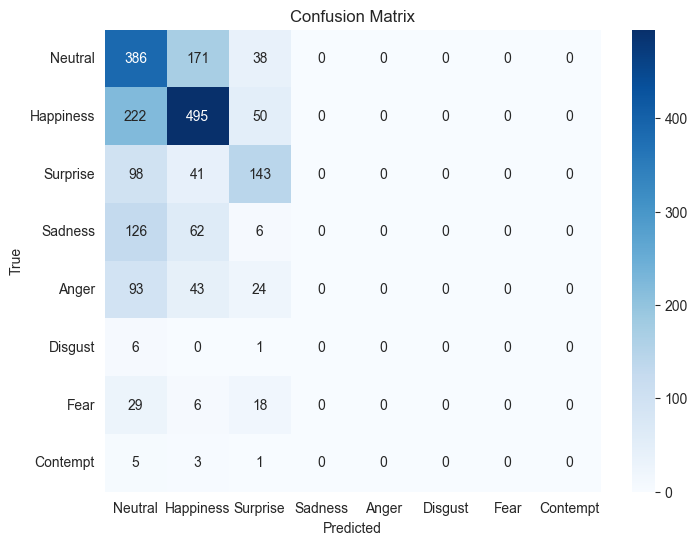

In [11]:
emotion_labels = [
    "Neutral", "Happiness", "Surprise", "Sadness",
    "Anger", "Disgust", "Fear", "Contempt"
]

all_labels = []  # True labels
all_predictions = []  # Model predictions

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Ensemble Methods
Combine predictions from multiple CNN models to create a robust ensemble model

In [12]:
import numpy as np

def ensemble_predict(models, dataloader, device):
    """
    Combine predictions from multiple models using an ensemble approach.

    Parameters:
    - models: List of trained models.
    - dataloader: DataLoader for validation or test data.
    - device: Device (CPU or GPU) for computation.

    Returns:
    - Final ensemble predictions.
    """
    all_predictions = []

    for inputs, _ in dataloader:
        inputs = inputs.to(device)

        # Store predictions from all models
        model_outputs = []
        for model in models:
            model.eval()
            with torch.no_grad():
                outputs = model(inputs)
                probs = nn.functional.softmax(outputs, dim=1)  # Convert logits to probabilities
                model_outputs.append(probs.cpu().numpy())

        # Average probabilities across models
        averaged_probs = np.mean(model_outputs, axis=0)  # Shape: [batch_size, num_classes]
        final_predictions = np.argmax(averaged_probs, axis=1)  # Final predicted classes
        all_predictions.extend(final_predictions)

    return np.array(all_predictions)

In [17]:
custom_model = torch.load("models/model_80.pth")
resnet50_model = model

ensemble_models = [resnet50_model, custom_model]

# Example: Evaluate on test set
ensemble_predictions = ensemble_predict(ensemble_models, test_loader, device)
print("Ensemble Predictions:", )
ensemble_predictions

C:\Users\ruzte\AppData\Local\Temp\ipykernel_22324\932892560.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_model = torch.load("models/model_80.pth")


UnpicklingError: NEWOBJ class argument must be a type, not module

In [42]:
def interpret_ensemble_output(predictions, emotion_labels):
    """
    Interpret the output of ensemble predictions and return the most frequent emotion.

    Parameters:
    - predictions: Array of predicted class indices from the ensemble model.
    - emotion_labels: List of emotion labels corresponding to class indices.

    Returns:
    - most_frequent_emotion: The emotion label that occurs most frequently in predictions.
    """
    # Count occurrences of each prediction
    unique, counts = np.unique(predictions, return_counts=True)
    prediction_counts = dict(zip(unique, counts))

    # Find the most frequent prediction
    most_frequent_class = max(prediction_counts, key=prediction_counts.get)

    # Map class index to emotion label
    most_frequent_emotion = emotion_labels[most_frequent_class]

    return most_frequent_emotion

In [43]:
most_frequent_emotion = interpret_ensemble_output(ensemble_predictions, emotion_labels)
print("Most Frequent Emotion:", most_frequent_emotion)


NameError: name 'ensemble_predictions' is not defined